In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import optimizers,layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
train_files = []
mask_files =[]
for i in os.listdir("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/image/glioma"):
    train_files.append("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/image/glioma/"+i)
    mask_files.append("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/mask/glioma/"+i[:-4]+"_m.jpg")
for i in os.listdir("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/image/meningioma"):
    train_files.append("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/image/meningioma/"+i)
    mask_files.append("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/mask/meningioma/"+i[:-4]+"_m.jpg")
for i in os.listdir("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/image/notumor"):
    train_files.append("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/image/notumor/"+i)
    mask_files.append("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/mask/notumor/"+i[:-4]+"_m.jpg")
for i in os.listdir("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/image/pituitary"):
    train_files.append("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/image/pituitary/"+i)
    mask_files.append("/content/drive/MyDrive/Brain Tumor Segmentation Dataset/mask/pituitary/"+i[:-4]+"_m.jpg")


In [6]:
print(train_files[:10])
print(mask_files[:10])

['/content/Brain Tumor Segmentation Dataset/image/glioma/Tr-gl_0216.jpg', '/content/Brain Tumor Segmentation Dataset/image/glioma/Tr-gl_1178.jpg', '/content/Brain Tumor Segmentation Dataset/image/glioma/Tr-gl_0495.jpg', '/content/Brain Tumor Segmentation Dataset/image/glioma/Tr-gl_1158.jpg', '/content/Brain Tumor Segmentation Dataset/image/glioma/Tr-glTr_0007.jpg', '/content/Brain Tumor Segmentation Dataset/image/glioma/Tr-gl_0585.jpg', '/content/Brain Tumor Segmentation Dataset/image/glioma/Tr-gl_0985.jpg', '/content/Brain Tumor Segmentation Dataset/image/glioma/Tr-gl_0720.jpg', '/content/Brain Tumor Segmentation Dataset/image/glioma/Tr-gl_1226.jpg', '/content/Brain Tumor Segmentation Dataset/image/glioma/Tr-gl_0633.jpg']
['/content/Brain Tumor Segmentation Dataset/mask/glioma/Tr-gl_0216_m.jpg', '/content/Brain Tumor Segmentation Dataset/mask/glioma/Tr-gl_1178_m.jpg', '/content/Brain Tumor Segmentation Dataset/mask/glioma/Tr-gl_0495_m.jpg', '/content/Brain Tumor Segmentation Dataset/m

In [7]:
im_width = 128
im_height = 128


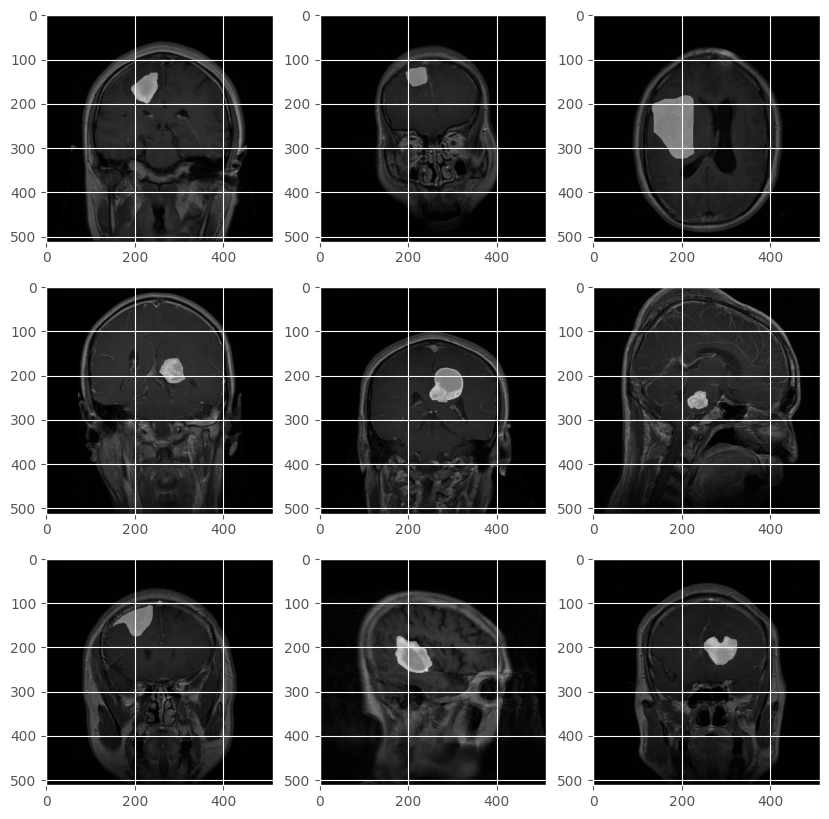

In [8]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [9]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(3050, 2)
(763, 2)
(424, 2)


In [10]:

def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):


    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [11]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [42]:
def resblock(X, f):
    X_copy = X  

    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)


    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)


    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    X = tf.keras.layers.Add()([X, X_copy])


    return X

def upsample_concat(x, skip):

    X = UpSampling2D((2,2))(x)
    merge = concatenate([X, skip])

    return merge

input_shape = (128,128,3)
X_input = Input(input_shape) 

conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPooling2D((2,2))(conv_1)

conv_2 = resblock(pool_1, 32)
pool_2 = MaxPooling2D((2,2))(conv_2)

conv_3 = resblock(pool_2, 64)
pool_3 = MaxPooling2D((2,2))(conv_3)

conv_4 = resblock(pool_3, 128)
pool_4 = MaxPooling2D((2,2))(conv_4)

conv_5 = resblock(pool_4, 256)

up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

model = Model(X_input, out)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_184 (Conv2D)         (None, 128, 128, 16)         448       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_140 (B  (None, 128, 128, 16)         64        ['conv2d_184[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_185 (Conv2D)         (None, 128, 128, 16)         2320      ['batch_normalization_14

In [43]:
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4

In [44]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))




opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('/content/drive/MyDrive/resunet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]


In [45]:

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gener,verbose=1,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 3050 validated image filenames.
Found 3050 validated image filenames.
Epoch 1/50
96/95 [==============================] - ETA: 0s - loss: -0.0590 - binary_accuracy: 0.6980 - iou: 0.0313 - dice_coef: 0.0597Found 763 validated image filenames.
Found 763 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02590, saving model to resunet_brain_mri_seg.hdf5
95/95 [==============================] - 49s 325ms/step - loss: -0.0590 - binary_accuracy: 0.6980 - iou: 0.0313 - dice_coef: 0.0597 - val_loss: -0.0259 - val_binary_accuracy: 0.1431 - val_iou: 0.0132 - val_dice_coef: 0.0259
Epoch 2/50
96/95 [==============================] - ETA: 0s - loss: -0.3632 - binary_accuracy: 0.9749 - iou: 0.2401 - dice_coef: 0.3658
Epoch 2: val_loss improved from -0.02590 to -0.11455, saving model to resunet_brain_mri_seg.hdf5
95/95 [==============================] - 31s 328ms/step - loss: -0.3632 - binary_accuracy: 0.9749 - iou: 0.2401 - dice_coef: 0.3658 - val_loss: -0.1145 - val_binary_

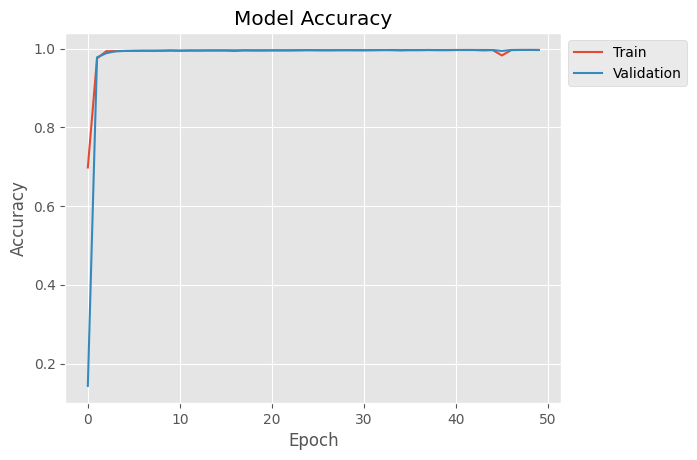

In [46]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

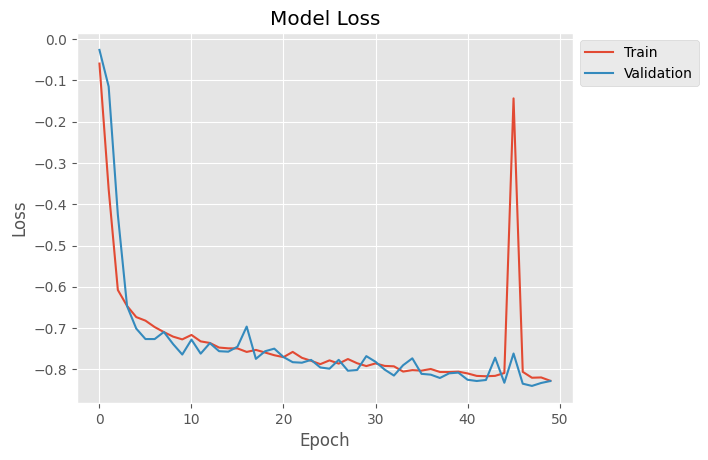

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

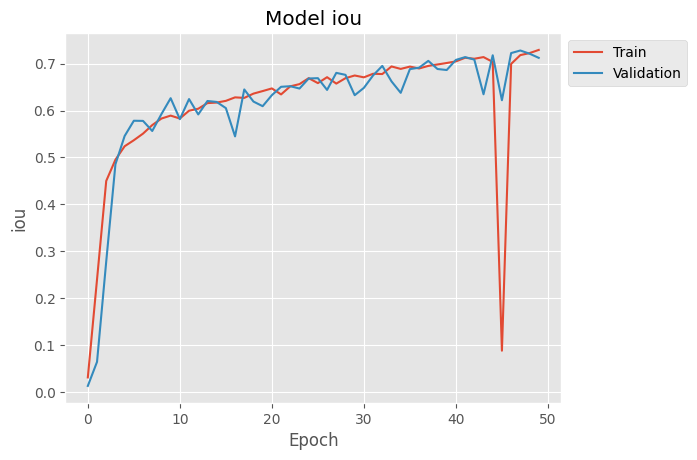

In [48]:
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('Model iou')
plt.ylabel('iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

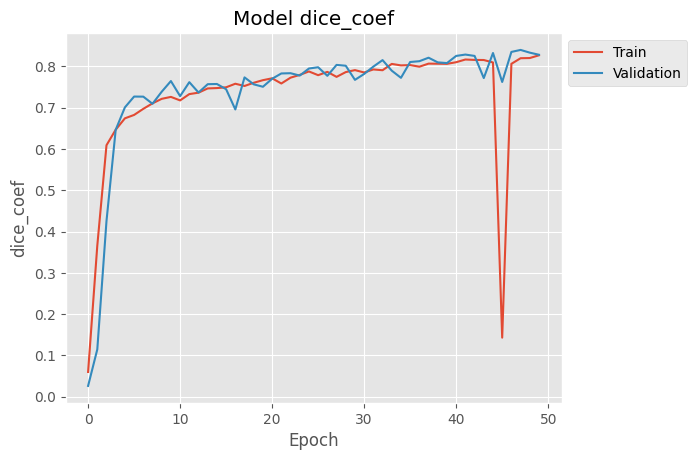

In [49]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()